In [1]:
import itertools
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import functools 
from itertools import product
import sys
sys.path.append('../Environments/')
from ColoredGridWorld import SetUpInferenceSpace as setUp
from ColoredGridWorld.MDP import MDP
from ColoredGridWorld import OBMDP
from ColoredGridWorld import visualizations
sys.path.append('../Algorithms/')
from ActionInterpretation import ActionInterpretation
from ValueIteration import ValueIteration
from DictValueIteration import ValueIteration as DictValueIteration
import pprint
import copy
from numpy.random import choice

In [2]:
def getJointTrajectory(jointState, policyTable, goal, jointTransitionFn, mostLikelyTraj = False):
    objectLevelTraj = [jointState[0]]
    jointTraj = [jointState]
    if(mostLikelyTraj):
        while(jointState[0]!=goal):
            action = max(policyTable[jointState], key=policyTable[jointState].get)
            jointState = max(jointTransitionFn(jointState, action), key = jointTransitionFn(jointState, action).get)
            objectLevelTraj.append(jointState[0])
            jointTraj.append(jointState)
    else:
        while(jointState[0]!=goal):
            actions = [action for action in policyTable[jointState].keys()]
            actionProbs = [policyTable[jointState][action] for action in actions]
            actionIndex = (choice(len(actions), p=actionProbs))
            action = actions[actionIndex]
            nextJointStates = [nextJointState for nextJointState in jointTransitionFn(jointState, action).keys()]
            nextJointStateProbs = [jointTransitionFn(jointState, action)[nextJointState] for nextJointState in nextJointStates]
            jointStateIndex = (choice(len(nextJointStates), p=nextJointStateProbs)) 
            jointState = nextJointStates[jointStateIndex]
            objectLevelTraj.append(jointState[0])
            jointTraj.append(jointState)
    return (objectLevelTraj, jointTraj)

In [3]:
dimensions = (5,6)
goals = [(5,2)]
goalState = (5,2)
actions = {(-1,0),(0,1),(0,-1),(1,0)}
goalNameDictionary = {(5,2):'goal'}
colourReward = {'white': 0, 'orange': -2, 'purple': 0, 'blue':0, 'yellow':10}
stateSpace = {(0,0): 'white',(0,1): 'white',(0,2): 'white',(0,3): 'white',(0,4): 'white', (1,0): 'blue',(1,1): 'orange', (1,2):'orange',(1,3):'orange',(1,4):'orange', (2,0): 'blue',(2,1):'purple', (2,2):'purple', (2,3):'purple', (2,4):'orange', (3,0): 'blue',(3,1):'purple',(3,2): 'blue',(3,3):'purple',(3,4):'orange', (4,0): 'blue', (4,1): 'blue', (4,2): 'blue',(4,3):'purple', (4,4):'orange', (5,0):'white',(5,1):'white', (5,2):'yellow', (5,3):'white', (5,4):'white'}
getMDP = MDP(dimensions, stateSpace, colourReward)
objectRewardFn = getMDP()

#set up for value-iteration and inference
convergenceTolerance = 10e-6
gamma = 0.95
alpha = 20
eps = 0.05
hyperparameters = (convergenceTolerance, gamma, alpha, eps)
variableColours = ['orange', 'purple', 'blue']
variableReward = [0, -2]
constantRewardDict = {'white': 0, 'yellow': 10}


utilitySpace = setUp.buildUtilitySpace(variableColours, variableReward, constantRewardDict)
transitionSpace = [True]
worlds = setUp.buildWorldSpace(utilitySpace, transitionSpace)
envSpace = [(world, goal) for world, goal in product(worlds, goals)]
envMDPsAndPolicies = setUp.buildEnvPolicySpace(dimensions, stateSpace, actions, envSpace, hyperparameters)
actionInterpretation = ActionInterpretation(envMDPsAndPolicies)

#set up for OBMDP and its value iteration 
beta = 10
beliefGamma = 0.95
beliefAlpha = 20
beliefEps = 0.05
#bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.25,0.5,0.75,1]
beliefSpacePossible = [{key:value for key, value in zip(envSpace, permutations)} for permutations in product(bins, repeat = len(envSpace))]
discreteBeliefSpace = [beliefDict for beliefDict in beliefSpacePossible if (sum(value for value in beliefDict.values())==1)]
hashableDiscreteBeliefSpace = [setUp.HashableBelief(beliefDict) for beliefDict in discreteBeliefSpace]
uniformPriorBelief = setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               })
hashableDiscreteBeliefSpace.append(uniformPriorBelief)
beliefUtilityFn = OBMDP.getBeliefUtility()
literalObserver = OBMDP.LiteralObserver(actionInterpretation, discreteBeliefSpace)
getNextBelief = literalObserver.getNextDiscreteBelief
jointStateSpace = list(product(stateSpace.keys(), hashableDiscreteBeliefSpace))

getOBMDP = OBMDP.OBMDP((setUp.HashableWorld(colourReward, True), goals[0]), True, beta, getMDP.transitionFunction, getNextBelief)
jointRewardFn = getOBMDP(objectRewardFn, beliefUtilityFn)
#print(len(hashableDiscreteBeliefSpace))
#print(len(jointStateSpace))

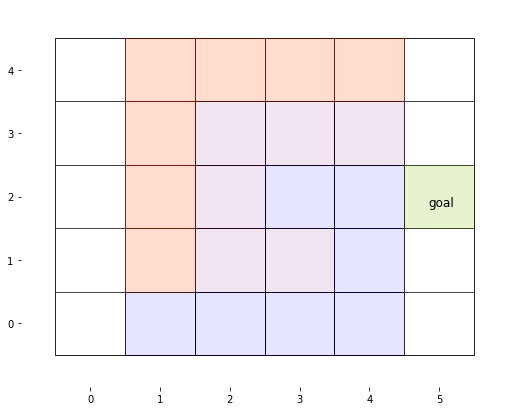

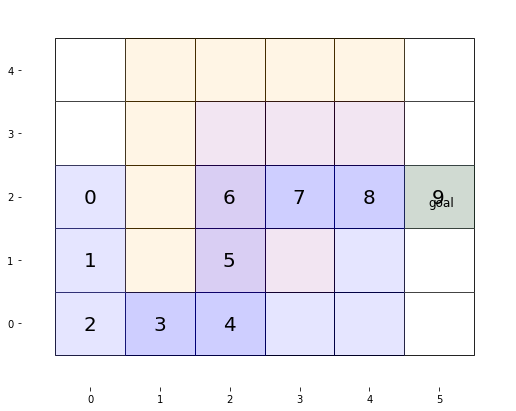

In [4]:
#implementing object-level MDP
valueTable = {key: 0 for key in stateSpace.keys()}
performValueIteration = ValueIteration(actions, getMDP.transitionFunction, objectRewardFn, valueTable, [goalState], convergenceTolerance, gamma, alpha, eps, True)
optimalValues, policyTable = performValueIteration()
trapStates = [s for s in stateSpace if(colourReward[stateSpace[s]]<0)]
n,m = dimensions 
visualizations.visualizeEnvironmentByState(stateSpace,[goalState], trapStates, [], goalNameDictionary, 1.75)

s = (0,2)
traj = [s]
while(s!=goalState):
    action = max(policyTable[s], key=policyTable[s].get)
    s = max(getMDP.transitionFunction(s,action), key = getMDP.transitionFunction(s,action).get)
    traj.append(s)
visualizations.visualizeEnvironmentByState(stateSpace, [goalState], [], traj, goalNameDictionary, 1.75)

In [5]:
import multiprocessing
import itertools
import time

class ActionTransition():
    def __init__(self, actionSpace, transitionFunction):
        self.actions = actionSpace
        self.getTransition = transitionFunction

    def __call__(self, jointState):
        return({action: self.getTransition(jointState, action) for action in self.actions})


In [6]:
"""
print(multiprocessing.cpu_count()) 
getActionDict = ActionTransition(actions, getOBMDP.transitionFunction)

# With parallelization
start_time = time.time()
with multiprocessing.Pool(processes=multiprocessing.cpu_count()-2) as executor:
    transitionTable = {state: actionDict for state, actionDict in zip(jointStateSpace, executor.map(getActionDict, jointStateSpace)) if state[0] != goalState }
print("--- %s seconds ---" % (time.time() - start_time))

#without parallelization
start_time = time.time()
transitionTable_NonParallel = {state: getActionDict(state) for state in jointStateSpace if state[0] != goalState }
print("--- %s seconds ---" % (time.time() - start_time))
"""

'\nprint(multiprocessing.cpu_count()) \ngetActionDict = ActionTransition(actions, getOBMDP.transitionFunction)\n\n# With parallelization\nstart_time = time.time()\nwith multiprocessing.Pool(processes=multiprocessing.cpu_count()-2) as executor:\n    transitionTable = {state: actionDict for state, actionDict in zip(jointStateSpace, executor.map(getActionDict, jointStateSpace)) if state[0] != goalState }\nprint("--- %s seconds ---" % (time.time() - start_time))\n\n#without parallelization\nstart_time = time.time()\ntransitionTable_NonParallel = {state: getActionDict(state) for state in jointStateSpace if state[0] != goalState }\nprint("--- %s seconds ---" % (time.time() - start_time))\n'

In [7]:
#implementing OBMDP
start_time = time.time()
jointTransitionDict = {jointState:{action:getOBMDP.transitionFunction(jointState, action) for action in actions} for jointState in jointStateSpace if jointState[0]!=goalState}
print("--- %s seconds ---" % (time.time() - start_time))

--- 428.61455941200256 seconds ---


In [8]:
jointRewardDict = copy.deepcopy(jointTransitionDict)
for jointState, actionAndNextStateDict in jointRewardDict.items():
    for action, nextJointStateAndProb in actionAndNextStateDict.items():
        for nextJointState in nextJointStateAndProb.keys():
            jointRewardDict[jointState][action][nextJointState] = jointRewardFn(jointState, action, nextJointState)
print("rewardDict done")

rewardDict done


In [9]:
valueTable = {key: 0 for key in jointStateSpace}
jointGoalStates = [jointState for jointState in jointStateSpace if jointState[0] == goalState]
performValueIteration = DictValueIteration(jointTransitionDict, jointRewardDict, valueTable, jointGoalStates, convergenceTolerance, beliefGamma, beliefAlpha, beliefEps)
optimalValues, policyTable = performValueIteration()
initialState1 = ( (0,2), setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               }) )

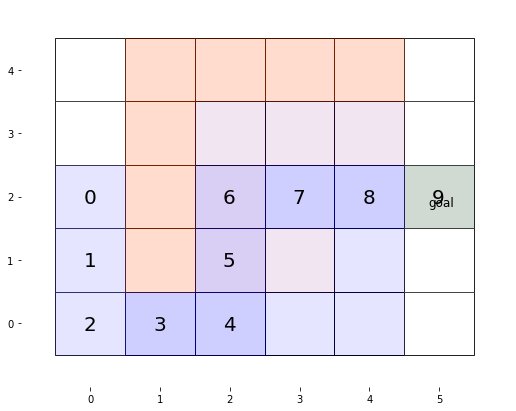

In [10]:
objectLevelTraj, jointTraj = getJointTrajectory(initialState1, policyTable, goalState, getOBMDP.transitionFunction, True)
#viewPolicyStructure(policyTable, ["state", "action", "probability"])
#visualizations.visualizeEnvironmentByState(stateSpace,[goalState], [], [], goalNameDictionary, 1.75)
visualizations.visualizeEnvironmentByState(stateSpace, [goalState], trapStates, objectLevelTraj, goalNameDictionary, 1.75)

In [11]:
orderOfColours = ["orange", "purple", "blue"]
beliefsAtEachStep = [jointState[1]() for jointState in jointTraj]
beliefsAtEachStepFinal = [setUp.mapEnvToLabel(envDict, orderOfColours) for envDict in beliefsAtEachStep]

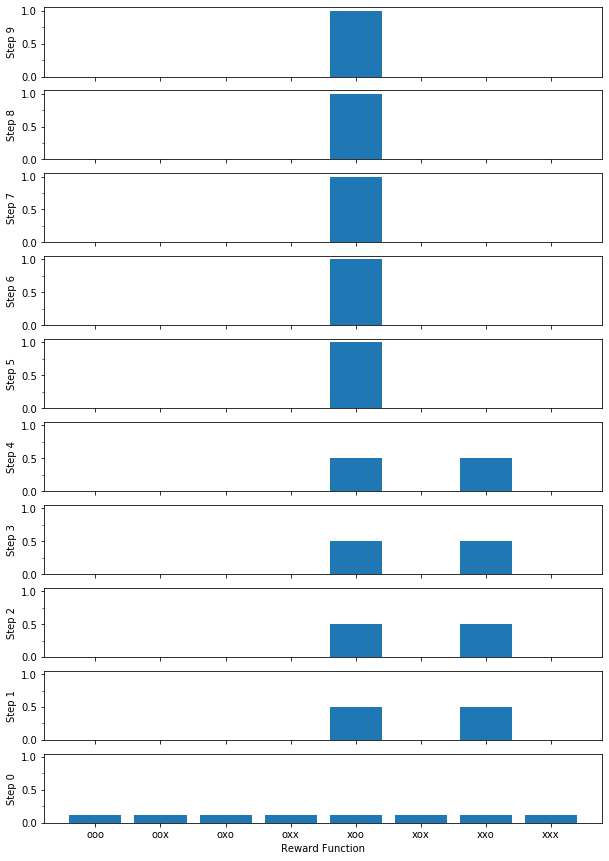

In [16]:
visualizations.plotDictAtEachStep(beliefsAtEachStepFinal, (10,15))

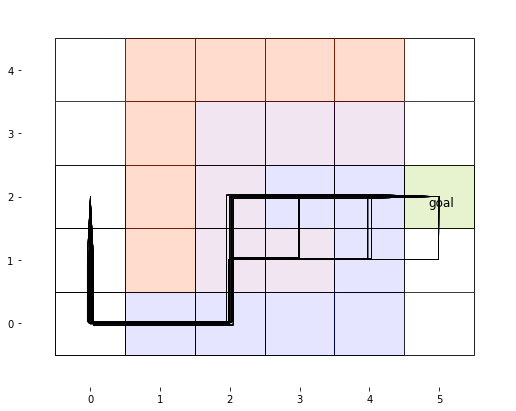

In [14]:
trajectories = []
for i in range(10):
    objectLevelTraj, jointTraj = getJointTrajectory(initialState1, policyTable, goalState, getOBMDP.transitionFunction)
    trajectories.append(objectLevelTraj)
visualizations.visualizeEnvironmentMultipleTraj(stateSpace, [goalState], trapStates, trajectories, goalNameDictionary, 1.75, 0, 0.03)